# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. The occurrences of terms and structures in each domain is what we refer to as the domain "archetype." Here, we'll assess whether the observed similarity between documents and the archetype is greater than expected by chance. This would indicate that information in the framework generalizes well to individual documents.

# Load the data

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
import utilities
from style import style

In [2]:
framework = "dsm" 
version = 190325 # Document-term matrix version
suffix = "_opsim" # Suffix for term lists
clf = "" # Classifier used to generate the framework
n_iter = 1000 # Iterations for null distribution
dx = [0.37, 0.37, 0.31, 0.37, 0.34, 0.37, 0.35, 0.35, 0.34] # Nudges for plotted means
alpha = 0.001 # Significance level for statistical comparisons

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [5]:
from collections import OrderedDict

In [6]:
lists, circuits = utilities.load_framework(framework, suffix=suffix, clf=clf)

In [7]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [8]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=200, Domain N=9


## Document structure-term vectors

In [9]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [10]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [11]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,acute_stress_disorder,adhd,adjustment_disorder,agoraphobia,alcohol_abuse,alcohol_use_disorder,alcohol_withdrawal,anxiety_disorder,aspergers_syndrome,attention_deficit_hyperactivity_disorder,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


## Document splits

In [12]:
splits = {}
splits["discovery"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["replication"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["replication"] += [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(pmids)))

Discovery    N=12708
Replication  N=5447


## Document assignments

In [13]:
doc2dom_df = pd.read_csv("../partition/data/doc2dom_{}{}.csv".format(framework, clf), 
                         header=None, index_col=0)
doc2dom = {int(pmid): str(dom.values[0]) for pmid, dom in doc2dom_df.iterrows()}

In [14]:
dom2docs = {dom: {split: [] for split in ["discovery", "replication"]} for dom in domains}
for doc, dom in doc2dom.items():
    for split, split_pmids in splits.items():
        if doc in splits[split]:
            dom2docs[dom][split].append(doc)

# Compute similarity to archetype

In [15]:
from scipy.spatial.distance import cdist

## Observed values

In [16]:
pmid_list, split_list, dom_list, obs_list  = [], [], [], []

for split, split_pmids in splits.items():
    split_list += [split] * len(split_pmids)
    
    for dom in domains:
        dom_pmids = dom2docs[dom][split]
        dom_vecs = docs.loc[dom_pmids].values
        dom_arche = archetypes[dom].values.reshape(1, archetypes.shape[0])
        dom_sims = 1.0 - cdist(dom_vecs, dom_arche, metric="dice")
        
        pmid_list += dom_pmids
        dom_list += [dom] * len(dom_sims)
        obs_list += list(dom_sims[:,0])

df_obs = pd.DataFrame({"PMID": pmid_list, "SPLIT": split_list, 
                       "DOMAIN": dom_list, "OBSERVED": obs_list})
df_obs.to_csv("data/arche_obs_{}{}.csv".format(framework, clf))  
df_obs.head()

,PMID,SPLIT,DOMAIN,OBSERVED
0,10327898,discovery,DEPRESSIVE,0.233333
1,10327899,discovery,DEPRESSIVE,0.244898
2,10459395,discovery,DEPRESSIVE,0.186047
3,10651872,discovery,DEPRESSIVE,0.095238
4,10974961,discovery,DEPRESSIVE,0.437500


## Null distributions

In [17]:
import os

In [18]:
df_null = {}
for split, split_pmids in splits.items():
    
    print("Processing {} split (N={} documents)".format(split, len(split_pmids)))
    
    file_null = "data/arche_null_{}{}_{}_{}iter.csv".format(framework, clf, split, n_iter)
    if not os.path.isfile(file_null):
        
        df_null[split] = np.zeros((len(domains), n_iter))
        for n in range(n_iter):
            null = np.random.choice(range(len(docs.columns)), 
                                    size=len(docs.columns), replace=False)
            for i, dom in enumerate(domains):
                dom_pmids = dom2docs[dom][split]
                dom_vecs = docs.loc[dom_pmids].values
                dom_arche = archetypes.values[null,i].reshape(1, archetypes.shape[0])
                df_null[split][i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
            if n % int(n_iter / 10.0) == 0:
                print("----- Processed {} iterations".format(n))
                
        df_null[split] = pd.DataFrame(df_null[split], index=domains, columns=range(n_iter))
        df_null[split].to_csv(file_null)
        print("")
    
    else:
        df_null[split] = pd.read_csv(file_null, index_col=0, header=0)

Processing discovery split (N=12708 documents)
Processing replication split (N=5447 documents)


## Interleave splits to facilitate plotting

In [19]:
df_null_interleaved = pd.DataFrame()
null_idx = []
for dom in domains:
    for split in ["discovery", "replication"]:
        df_null_interleaved = df_null_interleaved.append(df_null[split].loc[dom])
        null_idx.append(dom + "_" + split)
df_null_interleaved.index = null_idx
df_null_interleaved.head()

,0,1,10,100,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
DEPRESSIVE_discovery,0.087392,0.090019,0.084713,0.069871,0.090235,0.100957,0.088378,0.128570,0.071775,0.101024,...,0.143742,0.069787,0.064169,0.091321,0.066961,0.099880,0.081311,0.064979,0.108195,0.095059
DEPRESSIVE_replication,0.076693,0.102358,0.075633,0.077567,0.104562,0.120119,0.112411,0.080539,0.112253,0.119461,...,0.097480,0.058802,0.127961,0.075227,0.069091,0.100817,0.090822,0.086181,0.092377,0.106180
ANXIETY_discovery,0.104182,0.115655,0.138759,0.146916,0.110617,0.088854,0.086595,0.095755,0.085674,0.086208,...,0.115653,0.120809,0.096481,0.122165,0.109602,0.122179,0.095038,0.155609,0.127202,0.069281
ANXIETY_replication,0.091106,0.121219,0.107036,0.127267,0.097537,0.096262,0.109881,0.090058,0.139855,0.118374,...,0.162778,0.099366,0.127969,0.094110,0.149567,0.140847,0.098744,0.089651,0.093818,0.142346
TRAUMA_STRESSOR_discovery,0.075988,0.056565,0.075696,0.054962,0.099456,0.084426,0.061579,0.062763,0.062325,0.061231,...,0.072772,0.084681,0.109778,0.062979,0.078067,0.087965,0.055057,0.127461,0.061882,0.053874


## Bootstrap distributions

In [20]:
df_boot = {}
for split, split_pmids in splits.items():
    
    print("Processing {} split (N={} documents)".format(split, len(split_pmids)))
    
    file_boot = "data/arche_boot_{}{}_{}_{}iter.csv".format(framework, clf, split, n_iter)
    if not os.path.isfile(file_boot):
        
        df_boot[split] = np.zeros((len(domains), n_iter))
        for n in range(n_iter):
            boot = np.random.choice(range(len(docs.columns)), 
                                    size=len(docs.columns), replace=True)
            for i, dom in enumerate(domains):
                dom_pmids = dom2docs[dom][split]
                dom_vecs = docs.loc[dom_pmids].values[:,boot]
                dom_arche = archetypes.values[boot,i].reshape(1, archetypes.shape[0])
                df_boot[split][i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
            if n % int(n_iter / 10.0) == 0:
                print("----- Processed {} iterations".format(n))
        
        df_boot[split] = pd.DataFrame(df_boot[split], index=domains, columns=range(n_iter))
        df_boot[split].to_csv(file_boot)
        print("")
    
    else:
        df_boot[split] = pd.read_csv(file_boot, index_col=0, header=0)

Processing discovery split (N=12708 documents)
Processing replication split (N=5447 documents)


# Perform significance testing

In [21]:
from statsmodels.stats import multitest

In [22]:
df_stat = {}

for split, split_pmids in splits.items():
    
    df_stat[split] = pd.DataFrame(index=domains)
    
    pval = []
    for dom in domains:   
        dom_obs = df_obs.loc[(df_obs["SPLIT"] == split) & (df_obs["DOMAIN"] == dom), "OBSERVED"].mean()
        df_stat[split].loc[dom, "OBSERVED"] = dom_obs
        
        dom_null = df_null[split].loc[dom].values
        p = np.sum(dom_null >= dom_obs) / float(n_iter)
        pval.append(p)
        df_stat[split].loc[dom, "P"] = p
    
    df_stat[split]["FDR"] = multitest.multipletests(pval, method="fdr_bh")[1]
    
    for dom in domains:
        if df_stat[split].loc[dom, "FDR"] < alpha:
            df_stat[split].loc[dom, "STARS"] = "*"
        else:
            df_stat[split].loc[dom, "STARS"] = ""
    
    df_stat[split] = df_stat[split].loc[domains, ["OBSERVED", "P", "FDR", "STARS"]]
    df_stat[split].to_csv("data/arche_mean_{}{}_{}.csv".format(framework, clf, split))
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(df_stat[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
                      OBSERVED    P  FDR STARS
DEPRESSIVE            0.275163  0.0  0.0     *
ANXIETY               0.277979  0.0  0.0     *
TRAUMA_STRESSOR       0.291771  0.0  0.0     *
OBSESSIVE_COMPULSIVE  0.199777  0.0  0.0     *
DISRUPTIVE            0.258369  0.0  0.0     *
SUBSTANCE             0.221352  0.0  0.0     *
DEVELOPMENTAL         0.342707  0.0  0.0     *
PSYCHOTIC             0.249162  0.0  0.0     *
BIPOLAR               0.198779  0.0  0.0     *

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
                      OBSERVED    P  FDR STARS
DEPRESSIVE            0.276098  0.0  0.0     *
ANXIETY               0.275135  0.0  0.0     *
TRAUMA_STRESSOR       0.308598  0.0  0.0     *
OBSESSIVE_COMPULSIVE  0.207428  0.0  0.0     *
DISRUPTI

In [23]:
df_null["discovery"].mean(axis=1)

DEPRESSIVE              0.098283
ANXIETY                 0.118144
TRAUMA_STRESSOR         0.080807
OBSESSIVE_COMPULSIVE    0.066385
DISRUPTIVE              0.081606
SUBSTANCE               0.057859
DEVELOPMENTAL           0.221229
PSYCHOTIC               0.089351
BIPOLAR                 0.062698
dtype: float64

# Plot results

In [24]:
%matplotlib inline

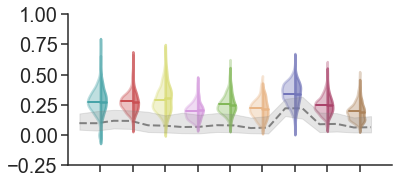

In [25]:
utilities.plot_split_violins(framework, domains, df_obs, df_null_interleaved, df_stat, 
                             style.palettes[framework], metric="arche", dx=dx,  
                             ylim=[-0.25,1], yticks=[-0.25,0,0.25,0.5,0.75,1], 
                             interval=0.999, alphas=[0], suffix=clf)